## 1. Searching for gold inside HTML files
<p>It used to take days for financial news to spread via radio, newspapers, and word of mouth. Now, in the age of the internet, it takes seconds. Did you know news articles are <em>automatically</em> being generated from figures and earnings call streams? Hedge funds and independent traders are using data science to process this wealth of information in the quest for profit.</p>
<p>In this notebook, we will generate investing insight by applying <a href="https://en.wikipedia.org/wiki/Sentiment_analysis">sentiment analysis</a> on financial news headlines from <a href="https://finviz.com">FINVIZ.com</a>. Using this <a href="https://en.wikipedia.org/wiki/Natural_language_processing">natural language processing</a> technique, we can understand the emotion behind the headlines and predict whether the market <em>feels</em> good or bad about a stock. It would then be possible to make educated guesses on how certain stocks will perform and trade accordingly. (And hopefully, make money!)</p>
<p><img src="images/fb_headlines.png" alt="Facebook headlines from FINVIZ.com"></p>
<p>Why headlines? And why from FINVIZ?</p>
<ol>
<li>Headlines, which have similar length, are easier to parse and group than full articles, which vary in length.</li>
<li>FINVIZ has a list of trusted websites, and headlines from these sites tend to be more consistent in their jargon than those from independent bloggers. Consistent textual patterns will improve the sentiment analysis.</li>
</ol>
<p>As <a href="https://en.wikipedia.org/wiki/Web_scraping">web scraping</a> requires data science ethics (sending a lot of traffic to a FINVIZ's servers isn't very nice), the HTML files for Facebook and Tesla at various points in time have been downloaded. Let's import these files into memory.</p>
<p><strong>Disclaimer: Investing in the stock market involves risk and can lead to monetary loss. The content in this notebook is not to be taken as financial advice.</strong> </p>

In [130]:
# Import libraries
import warnings
warnings.filterwarnings("ignore")
from bs4 import BeautifulSoup
import os

html_tables = {}

# For every table in the datasets folder...
for table_name in os.listdir('datasets'):
    #this is the path to the file. Don't touch!
    table_path = f'datasets/{table_name}'
    # Open as a python file in read-only mode
    table_file = open(table_path, 'r')
    # Read the contents of the file into 'html'
    html = BeautifulSoup(table_file)
    # Find 'news-table' in the Soup and load it into 'html_table'
    html_table = html.find(id='news-table')
    # Add the table to our dictionary
    html_tables[table_name] = html_table

## 2. What is inside those files anyway?
<p>We've grabbed the table that contains the headlines from each stock's HTML file, but before we start parsing those tables further, we need to understand how the data in that table is structured. We have a few options for this:</p>
<ul>
<li>Open the HTML file with a text editor (preferably one with syntax highlighting, like <a href="http://www.sublimetext.com/">Sublime Text</a>) and explore it there</li>
<li>Use your browser's <a href="https://addons.mozilla.org/en-US/firefox/addon/web-developer/">webdev toolkit</a> to explore the HTML</li>
<li>Explore the headlines table here in this notebook!</li>
</ul>
<p>Let's do the third option.</p>

In [132]:
# Read one single day of headlines 
tsla = html_tables['CTS_20230923.html']
# Get all the table rows tagged in HTML with <tr> into 'tesla_tr'
tsla_tr = tsla.findAll('tr')

# For each row...
for i, table_row in enumerate(tsla_tr):
    # Read the text of the element 'a' into 'link_text'
    link_text = table_row.a.get_text()
    # Read the text of the element 'td' into 'data_text'
    data_text = table_row.td.get_text()
    # Print the count
    print(f'File number {i+1}:')
    # Print the contents of 'link_text' and 'data_text' 
    print(link_text)
    print(data_text)
    # The following exits the loop after four rows to prevent spamming the notebook, do not touch
    if i == 3:
        break

File number 1:
Sidoti Events, LLCs Virtual September Small-Cap Conference

            Sep-19-23 09:00AM
        
File number 2:
CTS Corporation to Participate in Sidoti Virtual Investor Conference

            Sep-15-23 09:37AM
        
File number 3:
CTS Corporation Declares a Dividend

            Aug-17-23 04:15PM
        
File number 4:
Should You Be Confident in CTS Corporation (CTS)s Market Share Position?

            Aug-03-23 10:24AM
        


## 3. Extra, extra! Extract the news headlines
<p>As we saw above, the interesting data inside each table row (<code>&lt;tr&gt;</code>) is in the text inside the <code>&lt;td&gt;</code> and <code>&lt;a&gt;</code> tags. Let's now actually parse the data for <strong>all</strong> tables in a comfortable data structure.</p>

In [133]:
# Hold the parsed news into a list
parsed_news = []
# Iterate through the news
for file_name, news_table in html_tables.items():
    # Iterate through all tr tags in 'news_table'
    for x in news_table.findAll('tr'):
        # Read the text from the tr tag into text
        text = x.get_text() 
        # Split the /text in the td tag into a list 
        date_scrape = x.td.text.split()
        # If the length of 'date_scrape' is 1, load 'time' as the only element
        # If not, load 'date' as the 1st element and 'time' as the second
        if len(date_scrape) == 1:
            time = date_scrape[0]
        else:
            date = date_scrape[0]
            time = date_scrape[1]

        # Extract the ticker from the file name, get the string up to the 1st '_'  
        ticker = file_name.split("_")[0]
        # Append ticker, date, time and headline as a list to the 'parsed_news' list
        parsed_news.append([ticker, date, time, x.a.text])

## 4. Make NLTK think like a financial journalist
<p>Sentiment analysis is very sensitive to context. As an example, saying <em>"This is so addictive!"</em> often means something positive if the context is a video game you are enjoying with your friends, but it very often means something negative when we are talking about opioids. Remember that the reason we chose headlines is so we can try to extract sentiment from financial journalists, who like most professionals, have their own lingo. Let's now make NLTK think like a financial journalist by adding some new words and sentiment values to our lexicon.</p>

In [135]:

import nltk
#nltk.download('vader_lexicon')
# NLTK VADER for sentiment analysis
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# New words and values
new_words = {
    'crushes': 10,
    'beats': 5,
    'misses': -5,
    'trouble': -10,
    'falls': -100,
}

# Instantiate the sentiment intensity analyzer with the existing lexicon
vader = SentimentIntensityAnalyzer()

# Update the lexicon
vader.lexicon.update(new_words)

## 5. BREAKING NEWS: NLTK Crushes Sentiment Estimates
<p>Now that we have the data and the algorithm loaded, we will get to the core of the matter: programmatically predicting sentiment out of news headlines! Luckily for us, VADER is very high level so, in this case, we will not adjust the model further<sup>*</sup> other than the lexicon additions from before.</p>
<p><sup>*</sup>VADER "out-of-the-box" with some extra lexicon would likely translate into <strong>heavy losses</strong> with real money. A real sentiment analysis tool with chances of being profitable will require a very extensive and dedicated to finance news lexicon. Furthermore, it might also not be enough using a pre-packaged model like VADER.</p>

In [136]:
import pandas as pd

# Use these column names
columns = ['ticker', 'date', 'time', 'headline']

# Convert the list of lists into a DataFrame
scored_news = pd.DataFrame(parsed_news, columns=columns)

# Iterate through the headlines and get the polarity scores
scores = [vader.polarity_scores(head) for head in scored_news.headline]

# Convert the list of dicts into a DataFrame
scores_df = pd.DataFrame(scores)

# Join the DataFrames
scored_news = scored_news.join(scores_df)

# Convert the date column from string to datetime
scored_news['date'] = pd.to_datetime(scored_news.date).dt.date

## 6. Plot all the sentiment in subplots
<p>Now that we have the scores, let's start plotting the results. We will start by plotting the time series for the stocks we have.</p>

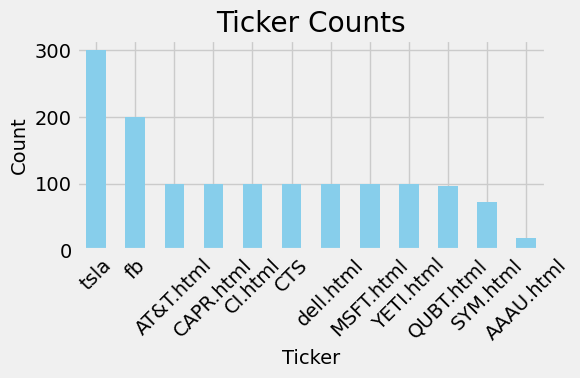

In [137]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming you have a DataFrame 'scored_news' with a 'ticker' column

# Count the occurrences of each ticker
ticker_counts = scored_news['ticker'].value_counts()

# Create a bar plot
plt.figure(figsize=(6,4))
ticker_counts.plot(kind='bar', color='skyblue')

# Add labels and a title
plt.xlabel('Ticker')
plt.ylabel('Count')
plt.title('Ticker Counts')

# Rotate x-axis labels for better readability (optional)
plt.xticks(rotation=45)

# Show the plot
plt.tight_layout()
plt.show()


## 7. Weekends and duplicates
<p>What happened to Tesla on November 22nd? Since we happen to have the headlines inside our <code>DataFrame</code>, a quick peek reveals that there are a few problems with that particular day: </p>
<ul>
<li>There are only 5 headlines for that day.</li>
<li>Two headlines are verbatim the same as another but from another news outlet.</li>
</ul>
<p>Let's clean up the dataset a bit, but not too much! While some headlines are the same news piece from different sources, the fact that they are written differently could provide different perspectives on the same story. Plus, when one piece of news is more important, it tends to get more headlines from multiple sources. What we want to get rid of is verbatim copied headlines, as these are very likely coming from the same journalist and are just being "forwarded" around, so to speak.</p>

In [138]:
# Count the number of headlines in scored_news (store as integer)
num_news_before = scored_news.headline.count()

# Drop duplicates based on ticker and headline
scored_news_clean = scored_news.drop_duplicates(subset= ['headline', 'ticker'])

# Count number of headlines after dropping duplicates
num_news_after = scored_news_clean.headline.count()

# Print before and after numbers to get an idea of how we did 
f"Before we had {num_news_before} headlines, now we have {num_news_after}"

'Before we had 1387 headlines, now we have 1331'

In [139]:
scored_news_clean.date.value_counts()

2019-01-02    66
2018-09-19    63
2018-09-20    52
2023-09-22    51
2019-01-04    48
              ..
2021-08-26     1
2023-08-15     1
2021-12-30     1
2022-03-02     1
2022-07-14     1
Name: date, Length: 369, dtype: int64

In [140]:
import pandas as pd
df = scored_news_clean
# Convert the 'date' column to string
df['date'] = df['date'].astype(str)

In [141]:
scored_news_clean[scored_news_clean['date'] == "2023-09-19"]

,ticker,date,time,headline,neg,neu,pos,compound
25,AT&T.html,2023-09-19,05:11PM,"Perini Management Services, Inc. Awarded $47 M...",0.000,0.856,0.144,0.4019
26,AT&T.html,2023-09-19,11:47AM,Lawyer who helped break up AT&T says DOJ has '...,0.000,0.805,0.195,0.5267
27,AT&T.html,2023-09-19,01:00AM,Apple iPhone 15 Deals Are Out. What They Mean ...,0.000,1.000,0.000,0.0000
28,AT&T.html,2023-09-19,12:31AM,Apple iPhone 15 launch sees major carriers off...,0.000,1.000,0.000,0.0000
219,CI.html,2023-09-19,06:15PM,Cigna (CI) Dips More Than Broader Markets: Wha...,0.000,1.000,0.000,0.0000
319,CTS,2023-09-19,09:00AM,"Sidoti Events, LLCs Virtual September Small-Ca...",0.000,1.000,0.000,0.0000
431,dell.html,2023-09-19,01:47PM,"SentinelOne (S), Mandiant Team Up to Strengthe...",0.000,0.753,0.247,0.3182
432,dell.html,2023-09-19,12:52PM,Intel Says Every PC Will Soon Be Capable of Ru...,0.000,0.809,0.191,0.3818
433,dell.html,2023-09-19,12:50PM,Dell Stock Gets an Upgrade as Demand Gets Stro...,0.135,0.631,0.234,0.2732
434,dell.html,2023-09-19,11:30AM,AMD Expands Fourth-Gen EPYC CPU Portfolio With...,0.000,0.851,0.149,0.1027


In [142]:
scored_news_clean.ticker.value_counts()

tsla         286
fb           190
dell.html    100
YETI.html     98
CAPR.html     97
MSFT.html     97
QUBT.html     96
AT&T.html     93
CI.html       92
CTS           92
SYM.html      71
AAAU.html     19
Name: ticker, dtype: int64

In [151]:
single_day = scored_news_clean.set_index(['ticker', 'date'])
single_day.head()

time  \
ticker    date                  
AAAU.html 2022-08-18  01:40PM   
          2022-01-19  05:50PM   
          2020-12-14  01:30PM   
          2020-12-14  08:00AM   
          2020-08-11  01:14PM   

                                                               headline  neg  \
ticker    date                                                                 
AAAU.html 2022-08-18                         Best Gold ETFs for Q4 2022  0.0   
          2022-01-19  Goldman Sachs Asset Management Announces Trans...  0.0   
          2020-12-14                        Goldman Takes Over Gold ETF  0.0   
          2020-12-14  Goldman Sachs Asset Management Announces Addit...  0.0   
          2020-08-11              Best Precious Metals ETFs for Q4 2020  0.0   

                        neu    pos  compound  
ticker    date                                
AAAU.html 2022-08-18  0.543  0.457    0.6369  
          2022-01-19  0.872  0.128    0.3612  
          2020-12-14  1.000  0.000    0.0000  
          2020-12-14  0.865  0.135    0.3612  
          2020-08-11  0.388  0.612    0.8360

In [155]:
# Take user input for stock_name and date
stock_name = input("Enter the stock name: ")
S_date = input("Enter the date (yyyy-mm-dd): ")
# Display the user inputs
print("Stock Name:", stock_name)
print("Date:", S_date)


Enter the stock name: AAAU.html
Enter the date (yyyy-mm-dd): 2020-12-14
Stock Name: AAAU.html
Date: 2020-12-14


## 8. Sentiment on one single trading day and stock
<p>Just to understand the possibilities of this dataset and get a better feel of the data, let's focus on one trading day and one single stock. We will make an informative plot where we will see the smallest grain possible: headline and subscores.</p>

In [157]:
# Set the index to ticker and date
single_day = scored_news_clean.set_index(['ticker', 'date'])

# Cross-section the 'fb' row
single_day = single_day.xs(stock_name, drop_level=False)  # Use drop_level=False to keep the 'ticker' level in the index

# Specify the date you want to select
selected_date =S_date

if selected_date in single_day.index.get_level_values('date'):
    # Select rows with the specified date
    single_day = single_day.loc[(slice(None), selected_date), :]

    # Convert the 'time' column to datetime.time objects
    single_day['time'] = pd.to_datetime(single_day['time']).dt.time

    # Set 'time' as the new index
    single_day = single_day.set_index('time')

    # Sort the DataFrame by the new index
    single_day = single_day.sort_index()
else:
    # Handle the case when the date is not found
    print(f"Date '{selected_date}' not found in the index. No data available for this date and stock.")


## 9. Visualize the single day
<p>We will make a plot to visualize the positive, negative and neutral scores for a single day of trading and a single stock. This is just one of the many ways to visualize this dataset.</p>

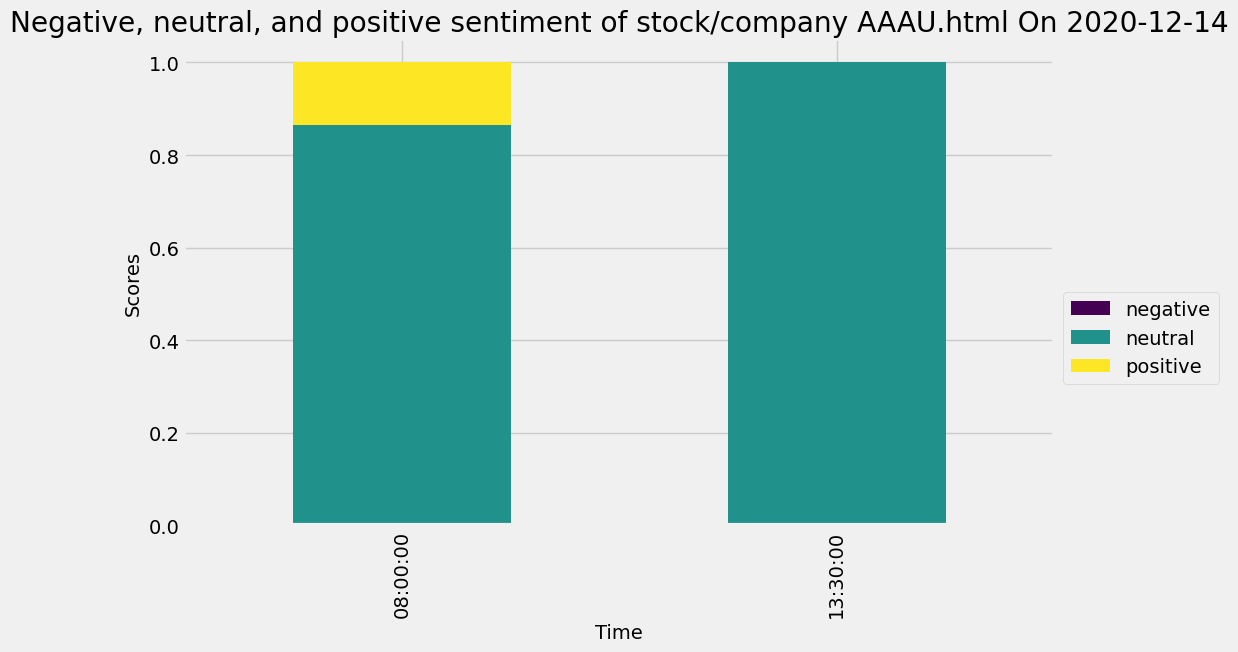

In [170]:
TITLE = "Negative, neutral, and positive sentiment for FB on 2020-12-14"
COLORS = ["red","orange", "green"]

# Drop the columns that aren't useful for the plot
plot_day = single_day.drop(['compound', 'headline'], 1)

# Change the column names to 'negative', 'positive', and 'neutral'
plot_day.columns = ['negative', 'neutral', 'positive']

# Plot a stacked bar chart
import matplotlib.pyplot as plt

# Define the title and colors

TITLE="Negative, neutral, and positive sentiment of stock/company " + stock_name+" " +"On "+ S_date

COLORS = ["red", "orange", "green"]

# Create a stacked bar plot
ax = plot_day.plot(kind='bar', stacked=True, figsize=(10, 6), colormap='viridis')
plt.title(TITLE)
plt.xlabel('Time')
plt.ylabel('Scores')

# Customize the legend location
plt.legend(loc='upper right', bbox_to_anchor=(1.2, 0.5))

# Show the plot
plt.show()